# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
#Imports necessários
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

from sklearn.preprocessing import (KBinsDiscretizer, OneHotEncoder,StandardScaler, 
                                   PolynomialFeatures, MinMaxScaler)

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import ( CountVectorizer, TfidfTransformer, TfidfVectorizer)


In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

#from IPython.core.pylabtools import figsize


#figsize(12, 8)

#sns.set()

In [3]:
countries = pd.read_csv("countries.csv")

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


### Criando DataFrame auxiliar

Para não manipularmos os dados do DataSet original, criaremos uma cópia destes dados em um Dataframe auxiliar.

In [5]:
aux = countries.copy()

In [6]:
aux.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [7]:
#Verificando a consistência dos dados
df = pd.DataFrame({'colunas' : aux.columns,
                    'tipo': aux.dtypes,
                    'nulos' : aux.isna().sum(),
                    'tamanho' : aux.shape[0],
                    'unicos': aux.nunique()})
df

,colunas,tipo,nulos,tamanho,unicos
Country,Country,object,0,227,227
Region,Region,object,0,227,11
Population,Population,int64,0,227,227
Area,Area,int64,0,227,226
Pop_density,Pop_density,object,0,227,219
Coastline_ratio,Coastline_ratio,object,0,227,151
Net_migration,Net_migration,object,3,227,157
Infant_mortality,Infant_mortality,object,3,227,220
GDP,GDP,float64,1,227,130
Literacy,Literacy,object,18,227,140


Observando o Dataframe verificamos que a maioria das variáveis (mesmo numéricas) são do tipo object e que há valores nulos entre elas.

## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

Antes de iniciarmos as questões transformaremos o delimitador das unidades de vírgula para ponto e as colunas de tipo object em float. 

In [9]:
variavel = ['Pop_density', 'Coastline_ratio', 'Net_migration', 'Infant_mortality', 'Literacy', 'Phones_per_1000', 'Arable','Climate', 'Crops', 'Other', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']

def format_variaveis(df, colunas):
    for col in colunas:
        df[col] = df[col].str.replace(',','.')
        df[col] = df[col].astype('float')

format_variaveis(aux, variavel)

O próximo passo é remover os espaços nas colunas Country e Region.

In [10]:
#Removendo os espaços
regiao = ['Country', 'Region']
def remove_espaco(df, colunas):
    for col in colunas:
        df[col] = df[col].str.strip()

remove_espaco(aux, regiao)

Verificando o DataSet que possuímos através da estatística descritiva de suas variáveis quantitativas.

In [11]:
#Variáveis transformadas em float e informações sobre a estatística descritiva
aux.describe()

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
mean,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.740000,0.769000,0.906000,0.954000


## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [12]:
def q1():
    regioes = np.sort(aux['Region'].unique()).tolist()
    return regioes
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [13]:
#Verificando a dimensão do DataSet
aux.shape

(227, 20)

O DataSet possui 227 linhas e 20 colunas.

Infomações sobre [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html).

In [14]:
#Criando um array auxiliar
densidade_pop= np.array(aux['Pop_density'])
    
#Discretizando a variável em 10 intervalos
discretizer = KBinsDiscretizer(n_bins=10,encode='ordinal', strategy='quantile')
    
#Fazemos um fit dos dados do dataframe auxiliar
discretizer.fit(densidade_pop.reshape(-1,1))

score_bins = discretizer.transform(aux[['Pop_density']])

In [15]:
def q2():
    #Criando uma nova coluna em um df auxiliar com os dados discretizados
    aux_discretizer= pd.concat([aux, pd.DataFrame(score_bins, columns=['Score_Pop_density'])], axis=1)
    #Verificando a quantidade de países acima do 90º percentil (dados unicos)
    paises = aux_discretizer[aux_discretizer['Score_Pop_density'] == 9]['Country'].nunique()
    return paises
q2()

23

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [16]:
def q3():
    #Treinando o Encoder
    one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)
    #Codificando as variáveis de Region  
    region_encoded = one_hot_encoder.fit_transform(aux[['Region']])
    region = region_encoded.shape[1]
    #Codificando as variáveis de Climate
    climate_encoded = one_hot_encoder.fit_transform(aux[['Climate']].dropna())
    climate=climate_encoded.shape[1]
    #Verificando os atributos
    atributos_criados = region + climate + 1
    return atributos_criados
q3()

18

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [17]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [18]:
#Preenchendo as variáveis int e float com as medianas
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("standard_scaler", StandardScaler())])

In [19]:
#Criando lista de colunas do Dataframe
colunas=list(aux.columns)
colunas

['Country',
 'Region',
 'Population',
 'Area',
 'Pop_density',
 'Coastline_ratio',
 'Net_migration',
 'Infant_mortality',
 'GDP',
 'Literacy',
 'Phones_per_1000',
 'Arable',
 'Crops',
 'Other',
 'Climate',
 'Birthrate',
 'Deathrate',
 'Agriculture',
 'Industry',
 'Service']

In [20]:
#Padronizando as variáveis
pipeline_transformation = num_pipeline.fit_transform(aux[colunas[2:]])

In [21]:
#Criando um novo DataSet com as variaveis resultantes do pipeline
aux_pipeline= pd.DataFrame(pipeline_transformation, columns=colunas[2:])

In [22]:
def q4():
    #Aplicando o pipeline no test_country
    test_country_pipeline=np.array(test_country).reshape(1,20)
    
    #Criando um novo dataset com as variáveis resultantes de test_country
    aux_test=pd.DataFrame(test_country_pipeline,columns=colunas)
    
    #aplicando o pipeline
    pipeline_test=num_pipeline.transform(aux_test.iloc[:,2:])
    
    #Criando um novo DataFrame
    aux_test_pipeline=pd.DataFrame(pipeline_test, columns=colunas[2:])

    return float(aux_test_pipeline['Arable'].round(3))

q4()

-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

Antes de mais nada iremos plotar o boxplot da variável Net_migration para verificarmos os *outliers*

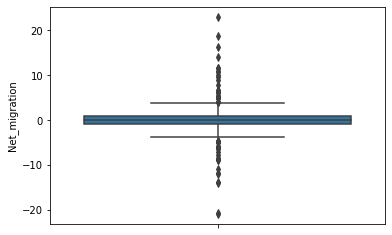

In [23]:
sns.boxplot(aux['Net_migration'], orient='vertical');

Verificaremos cada quartil:
    
Tudo que estiver fora de $x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ outlier}$ é considerado outlier.


In [24]:
#Primeiro quartil
q_1=aux['Net_migration'].quantile(0.25) 

#Segundo quartil
q_3=aux['Net_migration'].quantile(0.75) #segundo quartil

#Intervalo interquartil
iqr=q_3-q_1

intervalo=[q_1-1.5*iqr, q_3+1.5*iqr]
intervalo

[-3.8149999999999995, 3.885]

Tendo calculado o intervalo interquartil podemos identificar todos os pontos fora deste intervalo como *outliers*.

In [25]:
aux['Outlier']=pd.cut(aux['Net_migration'], bins=(-1000,intervalo[0],intervalo[1],1000), 
                      labels=('inferior', 'dentro_quartil', 'superior'))

In [26]:
def q5():
    outliers_abaixo=len(aux[aux['Outlier'] == 'inferior']['Outlier'])
    outliers_acima=len(aux[aux['Outlier'] == 'superior']['Outlier'])
    return (outliers_abaixo, outliers_acima,False)
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

Analizaremos *features* de texto nos 3 grupos descritos por categories para restringirmos nosso escopo:

In [27]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']

In [28]:
newsgroup = sk.datasets.fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
len(newsgroup.data)

1773

Agora temos um *corpus* com 1773 documentos.

In [29]:
#Aplicando o CountVectorizer
count_vectorizer = CountVectorizer()
newsgroups_counts = count_vectorizer.fit_transform(newsgroup.data)
newsgroups_counts

<1773x27335 sparse matrix of type '<class 'numpy.int64'>'
	with 227238 stored elements in Compressed Sparse Row format>

Abaixo verificamos a palavra **phone** no corpus 

In [30]:
#Verificando o numero de vezes que a palavra phone aparece
words_idx = sorted([count_vectorizer.vocabulary_.get(f"{word.lower()}") for word in
                    [u"phone"]])
words_idx

[19211]

In [42]:
def q6():
    num_phone=pd.DataFrame(newsgroups_counts[:, words_idx].toarray(), columns=np.array
                         (count_vectorizer.get_feature_names())[words_idx])
    return int (num_phone.sum())
q6()

213

A palavra phone aparece 213 vezes no dataset.

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

O tf-id verifica a frequência de ocorrência de uma determinada palavra.

É sempre um valor não negativo e quanto mais alto, maior a relevância do termo.

Podemos obter a matriz de tf-idf diretamente do corpus com o transformador TfidfVectorizer:

In [32]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(newsgroup.data)
newsgroup_tfidf_vectorized = tfidf_vectorizer.transform(newsgroup.data)
newsgroup_tfidf_vectorized.shape

(1773, 27335)

In [33]:
newsgroup_tfidf_vectorized[0,words_idx]

<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [36]:
def q7():
    tfidf_phone=pd.DataFrame(newsgroup_tfidf_vectorized[:, words_idx].toarray(), 
             columns=np.array(count_vectorizer.get_feature_names())[words_idx]).sum()
    return float (tfidf_phone.round(3))
q7()

8.888